# Environment Setup in GCP
- apt-get --purge remove "cublas" "cuda*"
- reboot
- sudo curl -O http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
- sudo dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
- sudo apt-get install cuda-10-1
- pip3 install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-geometric

** Both the PyTorch and torch_sparse CUDA version must matched

In [1]:
!python3 -c "import torch; print(torch.version.cuda)"

10.1


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
##########################################################################################
# This notebook works with Pytorch geometric GNNExplainer for explaining node predictions
# of Cora dataset and/or BA Graph with house motifs
# Created by : Au Jit Seah
# File owners : Au Jit Seah
##########################################################################################

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import sklearn.metrics as metrics

import time
from datetime import datetime

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import math

In [4]:
# Define all required arguments
class gnn_args:
    def __init__(self):
        self.datadir = "data"        # Directory where benchmark is stored (io_parser)
        self.logdir = "log"          # Tensorboard log directory
        self.ckptdir = "ckpt"        # Model checkpoint directory
        self.dataset = "BAGraph"     # Synthetic dataset, syn1
        self.opt = "adam"            # opt_parser
        self.opt_scheduler = "none"  # Optimizer scheduler
        self.max_nodes = 100         # Maximum number of nodes
                                     # (ignore graphs with nodes exceeding the number)
        self.cuda = "0"              # CUDA value
        self.feature_type = "default"# Feature used for encoder with possible values : id, deg
        self.lr = 0.001              # Learning rate
        self.clip = 2.0
        
        self.batch_size = 20         # Batch size
        self.num_epochs = 1000       # Number of epochs to train data
        self.train_ratio = 0.8       # Ratio of number of training set to all graphs
        self.test_ratio = 0.1
        self.num_workers = 1         # Number of workers to load data
        self.input_dim = 10          # Input feature dimension
        self.hidden_dim = 20         # Hidden layer dimension
        self.output_dim = 20         # Output layer dimension
        self.num_classes = 2         # Number of label classes
        self.num_gc_layers = 3       # Number of graph convolution layers before each pooling
        
        self.dropout = 0.0           # Dropout rate
        self.weight_decay = 0.005    # Weight decay regularization constant
        self.method = "base"         # Method used with possible values : base
        self.name_suffix = ""        # Suffix added to the output filename
        self.assign_ratio = 0.1      # Ratio of number of nodes in consecutive layers
        
        self.bias = True             # "Whether to add bias
        
        self.gpu = False             # Whether to use GPU
        self.linkpred = False        # Whether link prediction side objective is used
        self.bn = False              # Whether batch normalization is used
        self.bmname = None           # Name of the benchmark datase

prog_args = gnn_args()

# Generating synthetic graphs for GNN

In [5]:
# Create the BA-shape with house motifs and setting roles that will be used as labels
"""
Builds a BA preferential attachment graph, with "node index" starting from "start"
parameter and "role_ids" from "role_start" parameter

Input parameters :
----------------------------------------------------------------------------------------
start       :    starting index of the shape
width       :    int size of the graph (no. of nodes)
role_start  :    starting index for the roles

Return values :
----------------------------------------------------------------------------------------
graph       :    a ba graph, with ids beginning from start
roles       :    list of the roles of the nodes (indexed starting from
                 role_start) that will be used as labels
"""
def ba(start, width, role_start=0, m=5):
    graph = nx.barabasi_albert_graph(width, m)
    graph.add_nodes_from(range(start, start + width))
    nids = sorted(graph)
    mapping = {nid: start + i for i, nid in enumerate(nids)}
    graph = nx.relabel_nodes(graph, mapping)
    roles = [role_start for i in range(width)]
    return graph, roles

"""
Builds a house-like graph/motif, with "node index" starting from "start"
parameter and "role_ids" from "role_start" parameter

Input parameters :
----------------------------------------------------------------------------------------
start       :    starting index for the shape
role_start  :    starting index for the roles

Return values :
----------------------------------------------------------------------------------------
graph       :    a house-like graph/motif, with ids beginning from start
roles       :    list of the roles of the nodes (indexed starting at
                 role_start) that will be used as labels
"""
def house(start, role_start=0):
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    # graph.add_edges_from([(start, start + 2), (start + 1, start + 3)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles

In [6]:
"""
Creates a basis graph and attaches elements of the type in the list randomly along the basis.
Possibility to add random edges afterwards.

Input parameters :
----------------------------------------------------------------------------------------
width_basis       :      width (in terms of number of nodes) of the basis
basis_type        :      "ba"
shapes            :      list of shape list
                         (1st arg  : type of shape,
                         next args : args for building the shape except for the start)
start             :      initial node label for the first node
rdm_basis_plugins :      Boolean
                         For the shapes to be attached randomly (True) or
                         regularly (False) to the basis graph
add_random_edges  :      no. of edges to randomly add on the structure
m                 :      no. of new edges to attach to existing node (for BA graph)

Return values :
----------------------------------------------------------------------------------------
basis             :      a networkx graph with the particular shape used as the base
role_id           :      label for each role (eg. representing basis or edges)
plugins           :      node ids whereby the motif graph will be attached to the basis
"""
# Eg. build_graph(20, "ba", [["house"]], start=0, m=5)
def build_graph(width_basis, basis_type, list_shapes, start=0,
                rdm_basis_plugins=False,add_random_edges=0, m=5):
    print("------ Building the Synthetic BA graph with 'House' motifs ------")
    # Build the BA graph start with 0 and number of nodes (width basis)
    if basis_type == "ba":
        # Drawing of a house motif
        basis, role_id = eval(basis_type)(start, width_basis, m=m)
        print("Role Id of the BA graph :\n", role_id)
#     else:
#         # Drawing other type of motif
#         basis, role_id = eval(basis_type)(start, width_basis)

    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
    start += n_basis  # indicator of the id of the next node
    print("Indicator of the id of the next node :", start)
    
    # role_id are '0's for all the nodes of the basis, BA graph
    print("Number of nodes in the BA graph : ", n_basis)
    print("Number of motifs : ", n_shapes)

    print("List of shapes :", list_shapes)
    print("No. of shapes :", len(list_shapes))

    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        print("Spacing : ", spacing)
        plugins = [int(k * spacing) for k in range(n_shapes)]
        print("Plugins : ", plugins)
    seen_shapes = {"basis": [0, n_basis]}
    print("seen_shapes : ", seen_shapes)
    
    for shape_index, shape in enumerate(list_shapes):
        shape_type = shape[0]
        print("\n-----------------------------------------")
        print("Shape_ID : " + str(shape_index) + " with shape type : " + str(shape_type))
        print(str(len(shape)) + " shapes with list of Shape :", shape)
        print("The shape starts from index 1 : ", shape[1:])
        
        args = [start]
        
        # More than one shape
        if len(shape) > 1:
            args += shape[1:]
        
        # Append 0 for the "role_start" in "house" function
        args += [0]
        print("\nThe list of arguments :", args)
        # *args parameter to send a non-keyworded variable-length argument list to function, 1-2 parameters in this case
        print("The first item in list of arguments :", args[0])
        print("The second item in list of arguments :", args[1])
        
        # Creating the "house" motif
        graph_s, roles_graph_s = eval(shape_type)(*args)
        n_s = nx.number_of_nodes(graph_s)
        
        try:
             # Get the last seen label from first index
            col_start = seen_shapes[shape_type][0]
        except:
            # Get the max label value 1
            col_start = np.max(role_id) + 1
            # Add the new shape_type to the seen_shapes dictionary
            seen_shapes[shape_type] = [col_start, n_s]
        print("Column start :", col_start)
        print("Observe seen_shapes : ", seen_shapes)
        
        
        # Attach the shape to the basis, BA graph
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        # Connecting the motif to the BA graph from node 20 to 0, 25 to 6 and 30 to 12
        basis.add_edges_from([(start, plugins[shape_index])])
#         if shape_type == "cycle":
#             if np.random.random() > 0.5:
#                 a = np.random.randint(1, 4)
#                 b = np.random.randint(1, 4)
#                 basis.add_edges_from([(a + start, b + plugins[shape_id])])

        # start = 0; col_start = 1; roles_graph_s = [0, 0, 1, 1, 2]
        temp_labels = [r + col_start for r in roles_graph_s]
        # temp_labels increment roles_graph_s by col_start

        # temp_labels[0] += 100 * seen_shapes[shape_type][0]
        
        # role_id is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # Append labels of motif to the labels of BA graph
        role_id += temp_labels
        print("Labels of BA graph with attached motifs :\n", role_id)
        print("No. of nodes in attached graph : ", nx.number_of_nodes(basis))
        start += n_s
        print("With attached motif nodes, index starts from : ", start)

#     if add_random_edges > 0:
#         # add random edges between nodes:
#         for p in range(add_random_edges):
#             src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
#             print(src, dest)
#             basis.add_edges_from([(src, dest)])

    # Plotting the basis "BA" graph
    plt.figure(figsize=(20, 10))
    plt.title('BA graph'.upper(), y=1.0, fontsize=14)
    nx.draw(basis, with_labels=True, font_weight='bold')

    # Plot the motif "house" graph
    plt.figure(figsize=(2, 2))
    plt.title('"House" motif', y=1.0, fontsize=12)
    nx.draw(graph_s, with_labels=True, font_weight='bold')
    print("\nInformation of the motif graph :\n", nx.info(graph_s))
    
    plt.show()
            
    return basis, role_id, plugins

# Features generation

In [7]:
# Generating node features
import abc

class FeatureGen(metaclass=abc.ABCMeta):
    # Feature Generator base class from Abstract Base Classes
    @abc.abstractmethod
    def gen_node_features(self, G):
        pass

class ConstFeatureGen(FeatureGen):
    # Generate constant node features in class
    def __init__(self, val):
        print("Values in Constant Feature Generator : ", val)
        self.val = val

    def gen_node_features(self, G):
        print("Generate node features for " + str(len(G.nodes())) + " nodes.")
        feat_dict = {i:{'feat': np.array(self.val, dtype=np.float32)} for i in G.nodes()}
        print('Values of feat_dict[0]["feat"]:', feat_dict[0]['feat'])
        
        # Set node attributes with values in feature dictionary of values '1's
        nx.set_node_attributes(G, feat_dict)
        print('Node attributes of node \'0\', G.nodes[0]["feat"]:', G.nodes[0]['feat'])

# Generate Synthetic BA graph with "house" motifs

In [8]:
# Clean up graph and create its adjacency matrix
"""
Perturb the list of (sparse) graphs by adding/removing edges.

Input parameters :
----------------------------------------------------------------------------------------
graph_list           :      the list of graphs to be perturbed
p                    :      proportion of added edges based on current number of edges.

Return values :
----------------------------------------------------------------------------------------
perturbed_graph_list :      the list of graphs that are perturbed from the original graphs.
"""
def perturb(graph_list, p):
    perturbed_graph_list = []
    for G_original in graph_list:
        G = G_original.copy()
        edge_count = int(G.number_of_edges() * p)
        # randomly add the edges between a pair of nodes without an edge.
        for _ in range(edge_count):
            while True:
                u = np.random.randint(0, G.number_of_nodes())
                v = np.random.randint(0, G.number_of_nodes())
                if (not G.has_edge(u, v)) and (u != v):
                    break
            G.add_edge(u, v)
        perturbed_graph_list.append(G)
    return perturbed_graph_list

"""
Load an existing graph to be converted for the experiments.

Input parameters :
----------------------------------------------------------------------------------------
G                        :      Networkx graph is the input for preprocessing
labels                   :      corresponding node labels
normalize_adj            :      Boolean
                                returns a normalized adjacency matrix (True)

Return values :
----------------------------------------------------------------------------------------
{"adj", "feat" "labels"} :  dictionary containing adjacency, node features and labels
"""
def preprocess_input_graph(G, labels, normalize_adj=False):
    # Create the adjacency matrix for graph
    adj = np.array(nx.to_numpy_matrix(G))
    print("------ Preprocess Input graph ------")
    print("The shape of the adjacency matrix ('dxd') of input graph :", adj.shape)

    # If normalization is required
#     if normalize_adj:
#         # Create a diagonal array
#         sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
#         adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    # last index from 0 - 34
    existing_node = list(G.nodes)[-1]
    # Dimension of features
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    print("Feature dimensions of the last node '" + str(existing_node) + "' : " + str(feat_dim))

    # Initialize feature ndarray (dimension of number_of_nodes x feat_dim) 
    features = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for idx, node_id in enumerate(G.nodes()):
        features[idx, :] = G.nodes[node_id]["feat"]

    # add batch dim by expanding the shape horizontally
    adj = np.expand_dims(adj, axis=0)
    features = np.expand_dims(features, axis=0)
    labels = np.expand_dims(labels, axis=0)    
    print("The shape of the adjacency matrix after expansion :", adj.shape)
    print("The shape of the features matrix after expansion :", features.shape)
    print("The shape of the labels matrix after expansion :", labels.shape)
    
    return {"adj": adj, "feat": features, "labels": labels}


"""
Generating Synthetic Graph for experimentation :
- Barabasi-Albert base graph and attach the no. of "house" motifs

Input parameters :
----------------------------------------------------------------------------------------
nb_shapes         :  the no. of shapes ('house' motifs) that should be added to the
                     base graph
width_basis       :  the no. of nodes of the basis graph (ie. 'BA' graph)
feature_generator :  a `Feature Generator` for node features
                     addition of constant features to nodes ('None')
m                 :  no. of edges to be attached to existing node (for 'BA' graph)

Return values :
----------------------------------------------------------------------------------------
G                 :  a generated networkx "ba" graph with attached "house" motifs
role_id           :  a list with total number of nodes in the entire graph (base graph
                     and  motifs).  role_id[i] is the ID of the role of node i.
                     It is also the label used for training and predictions
name              :  a graph identifier
"""
def gen_syn1(nb_shapes=3, width_basis=20, feature_generator=None, m=5):
    basis_type = "ba"
    list_shapes = [["house"]] * nb_shapes

    plt.figure(figsize=(8, 6), dpi=300)

    # synthetic_structsim
    G, role_id, _ = build_graph(width_basis, basis_type, list_shapes, start=0, m=5)
    G = perturb([G], 0.01)[0]

    if feature_generator is None:
        # feature generator
        feature_generator = ConstFeatureGen(1)
    
    # Generate node features
    feature_generator.gen_node_features(G)

    name = basis_type + "_" + str(width_basis) + "_" + str(nb_shapes)
    
    print("------ Generated the Synthetic BA graph with 'House' motifs ------")
    print("Name of generated graph :", name)
    return G, role_id, name

In [9]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import numpy as np

# This is the basic Graph Convolution Network class inherited from torch.nn module
class GraphConv(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        add_self=False,
        normalize_embedding=False,
        dropout=0.0,
        bias=True,
        gpu=True,
        att=False,
    ):
        super(GraphConv, self).__init__()
        self.att = att
        self.add_self = add_self
        self.dropout = dropout
        if dropout > 0.001:
            self.dropout_layer = nn.Dropout(p=dropout)
        self.normalize_embedding = normalize_embedding
        self.input_dim = input_dim
        self.output_dim = output_dim
        if not gpu:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim)
                )
            if att:
                self.att_weight = nn.Parameter(torch.FloatTensor(input_dim, input_dim))
        else:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim).cuda())
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim).cuda()
                )
            if att:
                self.att_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, input_dim).cuda()
                )
        if bias:
            if not gpu:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim))
            else:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim).cuda())
        else:
            self.bias = None

        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, adj):
        if self.dropout > 0.001:
            x = self.dropout_layer(x)
        # deg = torch.sum(adj, -1, keepdim=True)
        if self.att:
            x_att = torch.matmul(x, self.att_weight)
            # import pdb
            # pdb.set_trace()
            att = x_att @ x_att.permute(0, 2, 1)
            # att = self.softmax(att)
            adj = adj * att

        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.add_self:
            self_emb = torch.matmul(x, self.self_weight)
            y += self_emb
        if self.bias is not None:
            y = y + self.bias
        if self.normalize_embedding:
            y = F.normalize(y, p=2, dim=2)
            # print(y[0][0])
        return y, adj

    
# Build the convolution layers for the GCN Graph Encoder
# This is where the node masks and embeddings are created with predictions in forward pass
class GcnEncoderGraph(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,           # output_dim
        label_dim,               # num_classes
        num_layers,              # num_gc_layers
        pred_hidden_dims=[],
        concat=True,
        bn=True,
        dropout=0.0,
        add_self=False,
        args=None,
    ):
      
        super(GcnEncoderGraph, self).__init__()
        self.concat = concat

        # add_self = add_self
        self.add_self = add_self

        # This value will change from 'True' if it is provided by the caller function
        self.bn = bn
        self.num_layers = num_layers
        self.num_aggs = 1

        self.bias = True        
        self.gpu = args.gpu
        print("*** Check received batch_size argument :", args.batch_size)
        print("*** Batch normalization from caller (default : False) :", bn)

        if args.method == "att":
            self.att = True
        else:
            self.att = False
        if args is not None:
            self.bias = args.bias

        self.conv_first, self.conv_block, self.conv_last = self.build_conv_layers(
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers,
            add_self,
            normalize=True,
            dropout=dropout,
        )
        self.act = nn.ReLU()
        self.label_dim = label_dim

        if concat:
            self.pred_input_dim = hidden_dim * (num_layers - 1) + embedding_dim
        else:
            self.pred_input_dim = embedding_dim
        self.pred_model = self.build_pred_layers(
            self.pred_input_dim, pred_hidden_dims, label_dim, num_aggs=self.num_aggs
        )

        for m in self.modules():
            if isinstance(m, GraphConv):
                init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
                if m.att:
                    init.xavier_uniform_(
                        m.att_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.add_self:
                    init.xavier_uniform_(
                        m.self_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.bias is not None:
                    init.constant_(m.bias.data, 0.0)

    def build_conv_layers(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        num_layers,
        add_self,
        normalize=False,
        dropout=0.0,
    ):
        conv_first = GraphConv(
            input_dim=input_dim,
            output_dim=hidden_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        conv_block = nn.ModuleList(
            [
                GraphConv(
                    input_dim=hidden_dim,
                    output_dim=hidden_dim,
                    add_self=add_self,
                    normalize_embedding=normalize,
                    dropout=dropout,
                    bias=self.bias,
                    gpu=self.gpu,
                    att=self.att,
                )
                for i in range(num_layers - 2)
            ]
        )
        conv_last = GraphConv(
            input_dim=hidden_dim,
            output_dim=embedding_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        return conv_first, conv_block, conv_last

    def build_pred_layers(
        self, pred_input_dim, pred_hidden_dims, label_dim, num_aggs=1
    ):
        pred_input_dim = pred_input_dim * num_aggs
        if len(pred_hidden_dims) == 0:
            pred_model = nn.Linear(pred_input_dim, label_dim)
        else:
            pred_layers = []
            for pred_dim in pred_hidden_dims:
                pred_layers.append(nn.Linear(pred_input_dim, pred_dim))
                pred_layers.append(self.act)
                pred_input_dim = pred_dim
            pred_layers.append(nn.Linear(pred_dim, label_dim))
            pred_model = nn.Sequential(*pred_layers)
        return pred_model

    """
    For each num_nodes in batch_num_nodes, the first num_nodes entries of the 
    corresponding column are 1's, and the rest are 0's (to be masked out).
    Dimension of mask: [batch_size x max_nodes x 1]
    """
    def construct_mask(self, max_nodes, batch_num_nodes):
        # masks
        packed_masks = [torch.ones(int(num)) for num in batch_num_nodes]
        batch_size = len(batch_num_nodes)
        out_tensor = torch.zeros(batch_size, max_nodes)
        for i, mask in enumerate(packed_masks):
            out_tensor[i, : batch_num_nodes[i]] = mask
        return out_tensor.unsqueeze(2).cuda()

    """
    Batch normalization of 3D tensor x
    """
    def apply_bn(self, x):
        bn_module = nn.BatchNorm1d(x.size()[1])
        if self.gpu:
            bn_module = bn_module.cuda()
        return bn_module(x)

    """
    Perform forward prop with graph convolution.
    Returns:
        Embedding matrix with dimension [batch_size x num_nodes x embedding]
        The embedding dim is self.pred_input_dim
    """
    def gcn_forward(
        self, x, adj, conv_first, conv_block, conv_last, embedding_mask=None
    ):

        x, adj_att = conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        x_all = [x]
        adj_att_all = [adj_att]
        # out_all = []
        # out, _ = torch.max(x, dim=1)
        # out_all.append(out)
        for i in range(len(conv_block)):
            x, _ = conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            x_all.append(x)
            adj_att_all.append(adj_att)
        x, adj_att = conv_last(x, adj)
        x_all.append(x)
        adj_att_all.append(adj_att)
        # x_tensor: [batch_size x num_nodes x embedding]
        x_tensor = torch.cat(x_all, dim=2)
        if embedding_mask is not None:
            x_tensor = x_tensor * embedding_mask
        self.embedding_tensor = x_tensor

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)
        return x_tensor, adj_att_tensor

    def forward(self, x, adj, batch_num_nodes=None, **kwargs):
        # Embedding mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            self.embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            self.embedding_mask = None

        # Convolution
        x, adj_att = self.conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        out_all = []
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        adj_att_all = [adj_att]
        for i in range(self.num_layers - 2):
            x, adj_att = self.conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            out, _ = torch.max(x, dim=1)
            out_all.append(out)
            if self.num_aggs == 2:
                out = torch.sum(x, dim=1)
                out_all.append(out)
            adj_att_all.append(adj_att)
        x, adj_att = self.conv_last(x, adj)
        adj_att_all.append(adj_att)
        # x = self.act(x)
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        if self.num_aggs == 2:
            out = torch.sum(x, dim=1)
            out_all.append(out)
        if self.concat:
            output = torch.cat(out_all, dim=1)
        else:
            output = out

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)

        self.embedding_tensor = output
        ypred = self.pred_model(output)
        # print(output.size())
        return ypred, adj_att_tensor

#     def loss(self, pred, label, type="softmax"):
#         # softmax + CE
#         if type == "softmax":
#             return F.cross_entropy(pred, label, size_average=True)
#         elif type == "margin":
#             batch_size = pred.size()[0]
#             label_onehot = torch.zeros(batch_size, self.label_dim).long().cuda()
#             label_onehot.scatter_(1, label.view(-1, 1), 1)
#             return torch.nn.MultiLabelMarginLoss()(pred, label_onehot)

        # return F.binary_cross_entropy(F.sigmoid(pred[:,0]), label.float())

# GCN Encoding of the nodes
class GcnEncoderNode(GcnEncoderGraph):    
    def __init__(self, input_dim, hidden_dim, embedding_dim, label_dim, num_layers,
                 pred_hidden_dims=[], concat=True,
                 bn=True, dropout=0.0, args=None,):
        super(GcnEncoderNode, self).__init__(
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims,
            concat,
            bn,
            dropout,
            args=args,
        )
        
        if hasattr(args, "loss_weight"):
            print("Loss weight: ", args.loss_weight)
            self.celoss = nn.CrossEntropyLoss(weight=args.loss_weight)
        else:
            self.celoss = nn.CrossEntropyLoss()

    def forward(self, x, adj, batch_num_nodes=None, **kwargs):
        # Embedding masks
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            embedding_mask = None

        self.adj_atts = []
        self.embedding_tensor, adj_att = self.gcn_forward(
            x, adj, self.conv_first, self.conv_block, self.conv_last, embedding_mask
        )
        pred = self.pred_model(self.embedding_tensor)
        return pred, adj_att

    def loss(self, pred, label):
        pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)

In [10]:
#####################################################################################
# (1) GcnEncoderNode(GcnEncoderGraph) -> build_conv_layers -> GraphConv
# build_conv_layers return conv_first, conv_block, conv_last
# (2) GcnEncoderNode(GcnEncoderGraph) -> self.pred_model = self.build_pred_layers
# build_pred_layers return pred_model
# (3) syn_task1 -> train_node_classifier -> save_checkpoint
#####################################################################################
# Create the GCN mode and encoding the nodes
def syn_task1(args, writer=None):
    # featgen.ConstFeatureGen
    # np.ones(input_dim, dtype=float) = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
    constant_feature = ConstFeatureGen(np.ones(args.input_dim, dtype=float))
    print("Constant feature generator : ", constant_feature.val)
    
    #feat_dict = {i:{'feat': np.array(constant_feature.val, dtype=np.float32)} for i in G.nodes()}
    #print ('Values of feat_dict[0]["feat"]:', feat_dict[0]['feat'])

    #nx.set_node_attributes(G, feat_dict)
    #print('Node attributes of node \'0\', G.nodes[0]["feat"]:', G.nodes[0]['feat'])

    # gengraph.gen_syn1
    # Create the BA graph with the "house" motifs
    G, labels, name = gen_syn1(feature_generator=constant_feature)

    # No .of classes from [0-3] for BA graph with house motifs
    num_classes = max(labels) + 1
    # Update number of classes in argument for training (Out of bounds error)
    args.num_classes = num_classes
    
    # GcnEncoderNode model
    print("------------ GCNEncoderNode Model ------------")
    print("Input dimensions :", args.input_dim)
    print("Hidden dimensions :", args.hidden_dim)
    print("Output dimensions :", args.output_dim)
    print("Number of classes in args :", args.num_classes)
    print("Number of GCN layers :", args.num_gc_layers)
    print("Method : ", args.method)

    model = GcnEncoderNode(args.input_dim, args.hidden_dim, args.output_dim,
                           args.num_classes, args.num_gc_layers, bn=args.bn, args=args)
    
    print("GcnEncoderNode model :\n", model)
    

#     if args.method == "att":
#         print("Method: att")
#         model = models.GcnEncoderNode(
#             args.input_dim,
#             args.hidden_dim,
#             args.output_dim,
#             num_classes,
#             args.num_gc_layers,
#             bn=args.bn,
#             args=args,
#         )
#     else:
#         print("Method:", args.method)
#         model = models.GcnEncoderNode(
#             args.input_dim,
#             args.hidden_dim,
#             args.output_dim,
#             num_classes,
#             args.num_gc_layers,
#             bn=args.bn,
#             args=args,
#         )
    if args.gpu:
        model = model.cuda()

    train_node_classifier(G, labels, model, args, writer=writer)
    
    return model

# Training

In [11]:
def evaluate_node(ypred, labels, train_idx, test_idx):
    _, pred_labels = torch.max(ypred, 2)
    pred_labels = pred_labels.numpy()

    pred_train = np.ravel(pred_labels[:, train_idx])
    pred_test = np.ravel(pred_labels[:, test_idx])
    labels_train = np.ravel(labels[:, train_idx])
    labels_test = np.ravel(labels[:, test_idx])

    result_train = {
        "prec": metrics.precision_score(labels_train, pred_train, average="macro"),
        "recall": metrics.recall_score(labels_train, pred_train, average="macro"),
        "acc": metrics.accuracy_score(labels_train, pred_train),
        "conf_mat": metrics.confusion_matrix(labels_train, pred_train),
    }
    result_test = {
        "prec": metrics.precision_score(labels_test, pred_test, average="macro"),
        "recall": metrics.recall_score(labels_test, pred_test, average="macro"),
        "acc": metrics.accuracy_score(labels_test, pred_test),
        "conf_mat": metrics.confusion_matrix(labels_test, pred_test),
    }
    return result_train, result_test

In [12]:
import os

'''
Generate label prefix for a graph model.
'''
def gen_prefix(args):
    if args.bmname is not None:
        name = args.bmname
    else:
        name = args.dataset
    name += "_" + args.method

    name += "_hdim" + str(args.hidden_dim) + "_odim" + str(args.output_dim)
    if not args.bias:
        name += "_nobias"
    if len(args.name_suffix) > 0:
        name += "_" + args.name_suffix
    return name


"""
Create filename for saving.

Args:
    args        :  the arguments parsed in the parser
    isbest      :  whether the saved model is the best-performing one
    num_epochs  :  epoch number of the model (when isbest=False)
"""
def create_filename(save_dir, args, isbest=False, num_epochs=-1):
    filename = os.path.join("./", save_dir, gen_prefix(args))
    os.makedirs(filename, exist_ok=True)

    if isbest:
        filename = os.path.join(filename, "best")
    elif num_epochs > 0:
        filename = os.path.join(filename, str(num_epochs))
    else:
        filename = os.path.join(filename, "BA_graph")

    path_filename = filename + "_model_dict.pth" # ".pth.tar"
    print("Created filename with path : ", path_filename)
    return path_filename

In [13]:
# gnn-model-explainer/utils/io_utils.py
"""
Save pytorch model checkpoint.

Input parameters :
----------------------------------------------------------------------------------------
model         : The PyTorch model to save.
optimizer     : The optimizer used to train the model.
args          : A dict of meta-data about the model.
num_epochs    : Number of training epochs.
isbest        : True if the model has the highest accuracy so far.
cg_dict       : A dictionary of the sampled computation graphs.

Output :
----------------------------------------------------------------------------------------
filename      : File saved in "ckpt" subdirectory
"""
def save_checkpoint(model, optimizer, args, num_epochs=-1, isbest=False, cg_dict=None):
    filename = create_filename(args.ckptdir, args, isbest, num_epochs=num_epochs)
    torch.save(
        {
            "epoch": num_epochs,
            "model_type": args.method,
            "optimizer": optimizer,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "cg": cg_dict,
        },
        filename
    )

In [14]:
# Train node classifier and save the prediction results
def train_node_classifier(G, labels, model, args, writer=None):
    # train/test split only for nodes
    num_nodes = G.number_of_nodes()
    
    # Training data with 80% ratio, labels_train.size()
    num_train = int(num_nodes * args.train_ratio)
    idx = [i for i in range(num_nodes)]

    # Shuffle for training
    np.random.shuffle(idx)
    train_idx = idx[:num_train]
    test_idx = idx[num_train:]

    # data = gengraph.preprocess_input_graph(G, labels)
    data = preprocess_input_graph(G, labels)
    labels_train = torch.tensor(data["labels"][:, train_idx], dtype=torch.long)
    adj = torch.tensor(data["adj"], dtype=torch.float)
    x = torch.tensor(data["feat"], requires_grad=True, dtype=torch.float)

    
#     scheduler, optimizer = train_utils.build_optimizer(
#         args, model.parameters(), weight_decay=args.weight_decay
#     )
    # list(testModel.parameters()) and list(filter_fn) to show contents
    # train_utils.build_optimizer 
    filter_fn = filter(lambda p : p.requires_grad, model.parameters())

    # args.opt == 'adam':
    optimizer = optim.Adam(filter_fn, lr=prog_args.lr, weight_decay=0.0)
    scheduler = None

    # Sets the module in training mode
    model.train()
    ypred = None
    for epoch in range(args.num_epochs):
        begin_time = time.time()
        model.zero_grad()

        if args.gpu:
            ypred, adj_att = model(x.cuda(), adj.cuda())
        else:
            ypred, adj_att = model(x, adj)
        ypred_train = ypred[:, train_idx, :]
        if args.gpu:
            loss = model.loss(ypred_train, labels_train.cuda())
        else:
            loss = model.loss(ypred_train, labels_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), args.clip)

        optimizer.step()
        #for param_group in optimizer.param_groups:
        #    print(param_group["lr"])
        elapsed = time.time() - begin_time

        # Obtain with Confusion matrices for Train and Test results
        result_train, result_test = evaluate_node(
            ypred.cpu(), data["labels"], train_idx, test_idx
        )
        
        if writer is not None:
            writer.add_scalar("loss/avg_loss", loss, epoch)
            writer.add_scalars(
                "prec",
                {"train": result_train["prec"], "test": result_test["prec"]},
                epoch,
            )
            writer.add_scalars(
                "recall",
                {"train": result_train["recall"], "test": result_test["recall"]},
                epoch,
            )
            writer.add_scalars(
                "acc", {"train": result_train["acc"], "test": result_test["acc"]}, epoch
            )

        if epoch % 10 == 0:
            print(
                "epoch: ",
                epoch,
                "; loss: ",
                loss.item(),
                "; train_acc: ",
                result_train["acc"],
                "; test_acc: ",
                result_test["acc"],
                "; train_prec: ",
                result_train["prec"],
                "; test_prec: ",
                result_test["prec"],
                "; epoch time: ",
                "{0:0.2f}".format(elapsed),
            )

        if scheduler is not None:
            scheduler.step()

    print("Confusion Matrix of train result :\n", result_train["conf_mat"])
    print("Confusion Matrix of test result :\n", result_test["conf_mat"])

    # Sets the module in evaluation mode for computational graph
    model.eval()
    if args.gpu:
        ypred, _ = model(x.cuda(), adj.cuda())
    else:
        ypred, _ = model(x, adj)

    cg_data = {
        "adj": data["adj"],
        "feat": data["feat"],
        "label": data["labels"],
        "pred": ypred.cpu().detach().numpy(),
        "train_idx": train_idx,
    }
    
    print("Labels of the Computational graph :\n", cg_data['label'])
    print("Prediction result of the Computational graph :\n", cg_data['pred'])
    print("Train index of the Computational graph data :\n", cg_data['train_idx'])
    # import pdb
    # pdb.set_trace()
    
    #io_utils.save_checkpoint
    save_checkpoint(model, optimizer, args, num_epochs=-1, cg_dict=cg_data)

Values in Constant Feature Generator :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Constant feature generator :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
------ Building the Synthetic BA graph with 'House' motifs ------
Role Id of the BA graph :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Indicator of the id of the next node : 20
Number of nodes in the BA graph :  20
Number of motifs :  3
List of shapes : [['house'], ['house'], ['house']]
No. of shapes : 3
Spacing :  6
Plugins :  [0, 6, 12]
seen_shapes :  {'basis': [0, 20]}

-----------------------------------------
Shape_ID : 0 with shape type : house
1 shapes with list of Shape : ['house']
The shape starts from index 1 :  []

The list of arguments : [20, 0]
The first item in list of arguments : 20
The second item in list of arguments : 0
Column start : 1
Observe seen_shapes :  {'basis': [0, 20], 'house': [1, 5]}
Labels of BA graph with attached motifs :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3]
No. of

<Figure size 2400x1800 with 0 Axes>

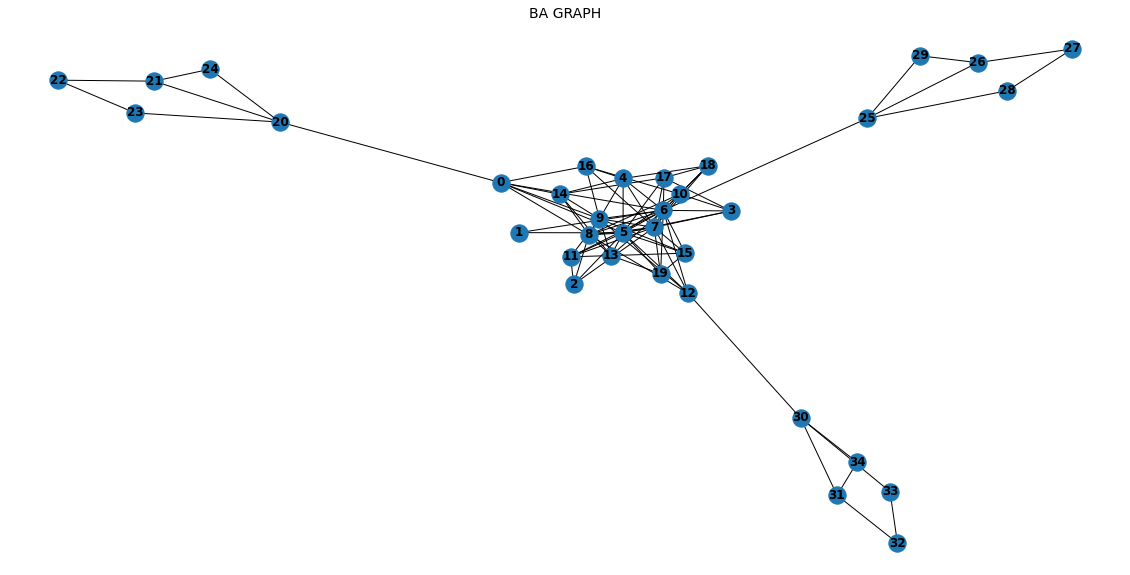

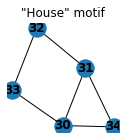

Generate node features for 35 nodes.
Values of feat_dict[0]["feat"]: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Node attributes of node '0', G.nodes[0]["feat"]: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
------ Generated the Synthetic BA graph with 'House' motifs ------
Name of generated graph : ba_20_3
------------ GCNEncoderNode Model ------------
Input dimensions : 10
Hidden dimensions : 20
Output dimensions : 20
Number of classes in args : 4
Number of GCN layers : 3
Method :  base
*** Check received batch_size argument : 20
*** Batch normalization from caller (default : False) : False
GcnEncoderNode model :
 GcnEncoderNode(
  (conv_first): GraphConv()
  (conv_block): ModuleList(
    (0): GraphConv()
  )
  (conv_last): GraphConv()
  (act): ReLU()
  (pred_model): Linear(in_features=60, out_features=4, bias=True)
  (celoss): CrossEntropyLoss()
)
------ Preprocess Input graph ------
The shape of the adjacency matrix ('dxd') of input graph : (35, 35)
Feature dimensions of the last node '34' : 10
The shape of

/home/samDev/ml/VirtualEnv/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch:  30 ; loss:  1.2050397396087646 ; train_acc:  0.5714285714285714 ; test_acc:  0.5714285714285714 ; train_prec:  0.14285714285714285 ; test_prec:  0.19047619047619047 ; epoch time:  0.00
epoch:  40 ; loss:  1.1767566204071045 ; train_acc:  0.5714285714285714 ; test_acc:  0.5714285714285714 ; train_prec:  0.14285714285714285 ; test_prec:  0.19047619047619047 ; epoch time:  0.00
epoch:  50 ; loss:  1.1576430797576904 ; train_acc:  0.5714285714285714 ; test_acc:  0.5714285714285714 ; train_prec:  0.14285714285714285 ; test_prec:  0.19047619047619047 ; epoch time:  0.00
epoch:  60 ; loss:  1.1457308530807495 ; train_acc:  0.5714285714285714 ; test_acc:  0.5714285714285714 ; train_prec:  0.14285714285714285 ; test_prec:  0.19047619047619047 ; epoch time:  0.00
epoch:  70 ; loss:  1.1378761529922485 ; train_acc:  0.5714285714285714 ; test_acc:  0.5714285714285714 ; train_prec:  0.14285714285714285 ; test_prec:  0.19047619047619047 ; epoch time:  0.00
epoch:  80 ; loss:  1.1309685707092

epoch:  600 ; loss:  0.07053159177303314 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  610 ; loss:  0.068255715072155 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  620 ; loss:  0.0663132295012474 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  630 ; loss:  0.06432954221963882 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  640 ; loss:  0.062463682144880295 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  650 ; loss:  0.06036490201950073 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  660 ; loss:  0.05862816795706749 ; train_acc:  1.0 ; test_acc:  1.0 ; train_prec:  1.0 ; test_prec:  1.0 ; epoch time:  0.00
epoch:  670 ; loss:  0.05704851821064949 ; train_acc:  1.0 ; test_acc: 

In [15]:
# train.py
# Call flow 1 : syn_task1 -> gen_syn1 -> build_graph -> ba
# Call flow 2 : syn_task1 -> GcnEncoderNode, train_node_classifier -> preprocess_input_graph
model = syn_task1(prog_args, writer=None)

In [16]:
model.eval()

GcnEncoderNode(
  (conv_first): GraphConv()
  (conv_block): ModuleList(
    (0): GraphConv()
  )
  (conv_last): GraphConv()
  (act): ReLU()
  (pred_model): Linear(in_features=60, out_features=4, bias=True)
  (celoss): CrossEntropyLoss()
)

In [17]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv_first.weight 	 torch.Size([10, 20])
conv_first.bias 	 torch.Size([20])
conv_block.0.weight 	 torch.Size([20, 20])
conv_block.0.bias 	 torch.Size([20])
conv_last.weight 	 torch.Size([20, 20])
conv_last.bias 	 torch.Size([20])
pred_model.weight 	 torch.Size([4, 60])
pred_model.bias 	 torch.Size([4])


In [18]:
# utils/io_utils.py
'''
Load a pre-trained pytorch model from checkpoint.
'''
def load_ckpt(args, isbest=False):

    print("Attempt to load model...")
    filename = create_filename(args.ckptdir, args, isbest)
    print("Loading file : ", filename)
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        ckpt = torch.load(filename)
    else:
        print("Checkpoint does not exist!")
        print("Check correct path for : {}".format(filename))
        print("Make sure you have provided the correct path!")
        print("Or you may have forgotten to train a model for this dataset.")
        print()
        print("To train one of the models, run the following")
        print(">> python train.py --dataset=DATASET_NAME")
        print()
        raise Exception("File is not found.")
    return ckpt

In [19]:
model_dict = load_ckpt(prog_args)
model_optimizer = model_dict['optimizer']
model_optimizer.state_dict()['param_groups']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

Attempt to load model...
Created filename with path :  ./ckpt/BAGraph_base_hdim20_odim20/BA_graph_model_dict.pth
Loading file :  ./ckpt/BAGraph_base_hdim20_odim20/BA_graph_model_dict.pth
=> loading checkpoint './ckpt/BAGraph_base_hdim20_odim20/BA_graph_model_dict.pth'


[{'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.0,
  'amsgrad': False,
  'params': [140253693376480,
   140253693374608,
   140253693376048,
   140253693374824,
   140253693374680,
   140253762697256,
   140253693722560,
   140253693719752]}]

In [20]:
print("Keys in loaded model dictionary :",list(model_dict))
print("Keys in loaded model optimizer dictionary:",list(model_optimizer.state_dict()))

Keys in loaded model dictionary : ['epoch', 'model_type', 'optimizer', 'model_state', 'optimizer_state', 'cg']
Keys in loaded model optimizer dictionary: ['state', 'param_groups']


In [21]:
model_dict['cg']['label']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3]])

# Preparation for PyTorch geometric

In [22]:
# gnn-model-explainer/utils/io_utils.py
use_cuda = torch.cuda.is_available()
use_cuda
#prog_args.bn
# Use `zero_division` parameter to control this behavior.

False

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

#print(len(trainset))
#print(trainset[10])

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to('cuda:0')
tb = torch.ones(2,2, dtype=float).to('cuda:0')

print(ta)
print(tb)
print(ta @ tb) # dot product; element-wise product

# This takes awhile for CUDA configurations

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device : ", device)

model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

In [ ]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [ ]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Removes every self-loop in the graph given by edge_index
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

In [ ]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [ ]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

In [ ]:
#pip3 install tensorboardX
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

In [ ]:
#get_ipython().system_raw(
#    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#    .format("./log")
#)


In [ ]:
#get_ipython().system_raw('./ngrok http 6006 &')
#!curl -s http://localhost:4040/api/tunnels | python3 -c \
#    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

print("Dataset :", dataset)
print("Length of dataset :", len(dataset))
print("Number of classes in dataset :", dataset.num_classes)
print("Number of node featues in dataset :", dataset.num_node_features)

# Have access to all 600 graphs in the datase
data = dataset[0]
print("\nDataset :", data)
print("\nIs the graph undirected :", data.is_undirected())

# Data(edge_index=[2, 168], x=[37, 3], y=[1])
# Data(edge_index=[2, 44], x=[12, 3], y=[1])
# The first graph in the dataset contains 12 nodes, each one having 3 features.
# There are 44/2 = 22 undirected edges and the graph is assigned to exactly one class.
# In addition, the data object is holding exactly one graph-level target.
train_dataset = dataset[:540]
test_dataset = dataset[540:]
print("Accessing dataset [0-539] for training :", train_dataset)
print("Accessing dataset [540-599] for testing :", test_dataset)

dataset = dataset.shuffle()
# Equivalent of the following
# perm = torch.randperm(len(dataset))
# dataset = dataset[perm]
print("Shuffle dataset :", dataset)

# Train model
print("\n----------- Model Training -----------")
model = train(dataset, task, writer)

# Mini-batches

In [ ]:
#https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
from torch_scatter import scatter_mean
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

count = 1
total_graphs = 0
for data in loader:
    # User batch to average node features in the node dimension for each graph individually
    x = scatter_mean(data.x, data.batch, dim=0)
    
    if count == 1:
        print("------------------------------ No. : " + str(count) + " ------------------------------")
        print("Batch :\n", data)
        print("No. of batch graphs :", data.num_graphs)
        print("Size of mean x in batch :\n", x.size())  
    count += 1
    total_graphs += data.num_graphs

print("----------------------------------------------------------------------")
print("Total no. of graphs in dataset :", total_graphs)

In [ ]:
# batch is a column vector which maps each node to its respective graph in the batch:
data.to_data_list()[0] # ['edge_index'] gives the mapping of each node

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

print("Dataset :\n", dataset)
print("Length of dataset :", len(dataset))
print("Number of classes in dataset :", dataset.num_classes)
print("Number of node featues in dataset :", dataset.num_node_features)

# Get a single, undirected citation graph from dataset
data = dataset[0]
print("\nDataset :\n", data)
print("Is single citation graph undirected :", data.is_undirected())

# data object holds a label for each node, and additional attributes :
# train_mask denotes against which nodes to train (140 nodes)
print("Number of items in train mask :", data.train_mask.sum().item())
# val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes)
print("Number of items in val mask :", data.val_mask.sum().item())
# test_mask denotes against which nodes to test (1000 nodes)
print("Number of items in test mask :", data.test_mask.sum().item())

# Train model
print("\n----------- Model Training -----------")
model = train(dataset, task, writer)

# Visualizing node embeddings

In [ ]:
color_list = ["red", "orange", "green", "blue", "purple", "brown",
              "black", "yellow", "grey", "cyan", "pink", "magenta"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))

plt.figure(figsize=(24, 20))
plt.scatter(xs, ys, color=colors)
plt.show()

# Graph methods
-  Graph Neural Network (GCN) <br>
(http://tkipf.github.io/graph-convolutional-networks/)

In [ ]:
dataset.num_node_features, dataset.num_classes

In [ ]:
from torch_geometric.nn import GCNConv

# A two-layer GCN
# Non-linearity is not integrated in the conv calls and hence needs to be applied afterwards
# Use ReLU as our intermediate non-linearity between and finally output a softmax distribution
# over the number of classes
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
print("Current device : ", device)

# Get a single, undirected citation graph from dataset
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

## GNN Explainer (pytorch_geometric/examples/gnn_explainer.py)

In [ ]:
# copied from pytorch_geometric/torch_geometric/nn/models/gnn_explainer.py
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.
    .. note::
        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.
    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """

    coeffs = {
        'edge_size': 0.005,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs=100, lr=0.01, log=True):
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.log = log

    def __set_masks__(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def __num_hops__(self):
        num_hops = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                num_hops += 1
        return num_hops

    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, edge_mask = k_hop_subgraph(
            node_idx, self.__num_hops__(), edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())

        x = x[subset]
        for key, item in kwargs:
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, edge_mask, kwargs

    def __loss__(self, node_idx, log_logits, pred_label):
        loss = -log_logits[node_idx, pred_label[node_idx]]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.
        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.
        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, hard_edge_mask, kwargs = self.__subgraph__(
            node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        with torch.no_grad():
            log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            log_logits = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.__loss__(0, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask

    def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
                           threshold=None, **kwargs):
        r"""Visualizes the subgraph around :attr:`node_idx` given an edge mask
        :attr:`edge_mask`.
        Args:
            node_idx (int): The node id to explain.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. (default: :obj:`None`)
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.
        :rtype: :class:`matplotlib.pyplot`
        """

        assert edge_mask.size(0) == edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, hard_edge_mask = k_hop_subgraph(
            node_idx, self.__num_hops__(), edge_index, relabel_nodes=True,
            num_nodes=None, flow=self.__flow__())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index, att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        kwargs['with_labels'] = kwargs.get('with_labels') or True
        kwargs['font_size'] = kwargs.get('font_size') or 10
        kwargs['node_size'] = kwargs.get('node_size') or 800
        kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))
        nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **kwargs)
        nx.draw_networkx_labels(G, pos, **kwargs)
        plt.axis('off')
        return plt

    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [ ]:
# copied from pytorch_geometric/torch_geometric/utils/subgraph.py
def maybe_num_nodes(index, num_nodes=None):
    return index.max().item() + 1 if num_nodes is None else num_nodes

def k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=False,
                   num_nodes=None, flow='source_to_target'):
    r"""Computes the :math:`k`-hop subgraph of :obj:`edge_index` around node
    :attr:`node_idx`.
    It returns (1) the nodes involved in the subgraph, (2) the filtered
    :obj`edge_index` connectivity, and (3) the edge mask indicating which edges
    were preserved.
    Args:
        node_idx (int): The central node.
        num_hops: (int): The number of hops :math:`k`.
        edge_index (LongTensor): The edge indices.
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        flow (string, optional): The flow direction of :math:`k`-hop
            aggregation (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)
    :rtype: (:class:`LongTensor`, :class:`LongTensor`, :class:`BoolTensor`)
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    assert flow in ['source_to_target', 'target_to_source']
    if flow == 'target_to_source':
        row, col = edge_index
    else:
        col, row = edge_index

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    subsets = [torch.tensor([node_idx], device=row.device).flatten()]
    for _ in range(num_hops):
        node_mask.fill_(False)
        node_mask[subsets[-1]] = True
        torch.index_select(node_mask, 0, row, out=edge_mask)
        subsets.append(col[edge_mask])
    subset = torch.cat(subsets).unique()
    # Add `node_idx` to the beginning of `subset`.
    subset = subset[subset != node_idx]
    subset = torch.cat([torch.tensor([node_idx], device=row.device), subset])

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    if relabel_nodes:
        node_idx = row.new_full((num_nodes, ), -1)
        node_idx[subset] = torch.arange(subset.size(0), device=row.device)
        edge_index = node_idx[edge_index]

    return subset, edge_index, edge_mask

In [ ]:
from torch_geometric.nn import GCNConv
from torch.nn import Sequential, Linear

dataset = 'Cora'
path = '/tmp/cora'

dataset = Planetoid(path, dataset, T.NormalizeFeatures())

# Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
data = dataset[0]
print("Data before sent to device :\n", data)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : ", device)

model = Net().to(device)
data = data.to(device)

print("Data to device :\n", data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
plt = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

plt.figure(figsize=(20, 20))
plt.show()

# Encoder for unsupervised training

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def unsupervised_train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def unsupervised_test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None

#data = model.split_edges(data)
data = pyg_utils.train_test_split_edges(data)

x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    unsupervised_train(epoch)
    auc, ap = unsupervised_test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

In [ ]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(24, 20))
plt.scatter(xs, ys, color=colors)
plt.show()

# End of Program